<a href="https://colab.research.google.com/github/yiwenwangANU/Machine_Learning/blob/main/Milestone_Project_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone Project 2: SkimLit 📄🔥

In this project, we're going to be replicating the deep learning model behind the 2017 paper PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts.

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order.

In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

![Skimlit example inputs and outputs](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/09-skimlit-overview-input-and-output.png)

*Example inputs ([harder to read abstract from PubMed](https://pubmed.ncbi.nlm.nih.gov/28942748/)) and outputs ([easier to read abstract](https://pubmed.ncbi.nlm.nih.gov/32537182/)) of the model we're going to build. The model will take an abstract wall of text and predict the section label each sentence should have.*  

#Cinform access to GPU

In [1]:
!nvidia-smi

Fri Jun 10 23:19:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Download the dataset from github

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), done.
Checking out files: 100% (13/13), done.


#Explore the data

In [3]:
!ls pubmed-rct

PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [5]:
# We use dataset under the directory 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign' in this project
train_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt'
val_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt'

In [6]:
with open(train_dir, 'r') as f:
  train_data_raw = f.readlines()
with open(val_dir, 'r') as f:
  val_data_raw = f.readlines()
# Raw data is in the form of list of strings
# For each abstract, it would start with string as '###' + id + \n, while end with a string of single \n
# In the middle, each sentence of the abstract was represented in the form of 'target class'(e.g. OBJECTIVE, METHOD) + original sentence
train_data_raw[:15]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

#Preprocess the data

## Seperate the list by each abstract 

In [7]:

def seperate_data_by_abstract(raw_data):
  data_seperated = []
  abstract = []
  for row in raw_data:
    if row.startswith('\n'):
      abstract.append(row)
      data_seperated.append(abstract)
      abstract = []     
    else:
      abstract.append(row)
  return data_seperated

In [8]:
train_data_seperated = seperate_data_by_abstract(train_data_raw)
val_data_seperated = seperate_data_by_abstract(val_data_raw)
train_data_seperated[:2]

[['###24293578\n',
  'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
  'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
  'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
  'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
  'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
  'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) -

## Create the pandas DataFrame for data input

In [9]:
import pandas as pd

def create_df_from_data(data_seperated):
  datalist = []
  for article in data_seperated:
    article = article[1:len(article)-1]
    sentence_list = []
    for i, sentence in enumerate(article):
      one_line = {}
      one_line['line_numbers'] = i
      one_line['target'] = sentence.split('\t')[0]
      one_line['text'] = sentence.split('\t')[1][:-1]
      one_line['total_lines'] =len(article)-1
      sentence_list.append(one_line)
    datalist.extend(sentence_list)

  df = pd.DataFrame(datalist)
  return df

In [10]:
train_df = create_df_from_data(train_data_seperated)
val_df = create_df_from_data(val_data_seperated)

In [11]:
train_df[:10]

,line_numbers,target,text,total_lines
0,0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,11
1,1,METHODS,A total of @ patients with primary knee OA wer...,11
2,2,METHODS,Outcome measures included pain reduction and i...,11
3,3,METHODS,Pain was assessed using the visual analog pain...,11
4,4,METHODS,Secondary outcome measures included the Wester...,11
5,5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",11
6,6,RESULTS,There was a clinically relevant reduction in t...,11
7,7,RESULTS,The mean difference between treatment arms ( @...,11
8,8,RESULTS,"Further , there was a clinically relevant redu...",11
9,9,RESULTS,These differences remained significant at @ we...,11


In [12]:
import random
ran_index = random.randint(5, len(train_df))
train_df[ran_index-5:ran_index]

,line_numbers,target,text,total_lines
23722,11,CONCLUSIONS,This study found a strong linear relationship ...,14
23723,12,CONCLUSIONS,The analysis of quantitative drug levels in ha...,14
23724,13,CONCLUSIONS,Hair measures for adherence monitoring may als...,14
23725,14,BACKGROUND,ClinicalTrials.gov NCT@ .,14
23726,0,OBJECTIVE,Talactoferrin alfa is a recombinant form of th...,12


In [13]:
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

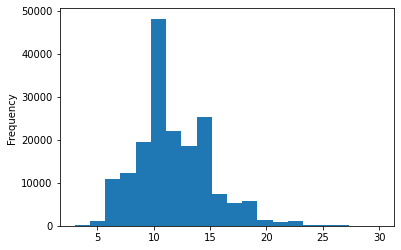

In [14]:
train_df['total_lines'].plot.hist(bins=20)

In [15]:
import numpy as np

np.percentile(train_df['total_lines'], 95)

18.0

In [16]:
train_text = train_df['text'].to_numpy() 
train_target = train_df['target'].to_numpy()
train_line_numbers = train_df['line_numbers'].to_numpy()
train_total_lines = train_df['total_lines'].to_numpy()

In [17]:
val_text = val_df['text'].to_numpy() 
val_target = val_df['target'].to_numpy()
val_line_numbers = val_df['line_numbers'].to_numpy()
val_total_lines = val_df['total_lines'].to_numpy()

In [18]:
# Label encode the target category
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_target_le = label_encoder.fit_transform(train_target)
val_target_le = label_encoder.transform(val_target)

In [19]:
# Record class names in a list
class_names = label_encoder.classes_
class_names

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

(array([21727.,     0., 27168.,     0.,     0., 59353.,     0., 13839.,
            0., 57953.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

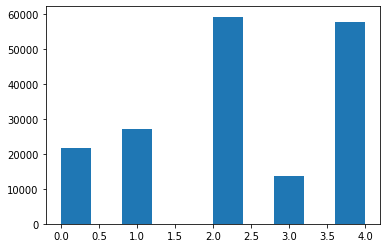

In [20]:
import matplotlib.pyplot as plt

plt.hist(train_target_le)

In [21]:
# One hot encode the target category
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_target_one_hot = one_hot_encoder.fit_transform(train_target.reshape(-1, 1))
val_target_one_hot = one_hot_encoder.transform(val_target.reshape(-1, 1))

In [22]:
train_target_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

#Model 0: Non-deep baseline model

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_text, 
            y=train_target_le);

In [24]:
model_0.score(val_text, val_target_le)

0.7218323844829869

In [25]:
model_0_pred = model_0.predict(val_text)

# Build the evaluation method

In [26]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

def evaluate_results(y_true, y_pred):
  model_accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_result = {'model_accuracy': model_accuracy,
                  'model_precision': model_precision,
                  'model_recall': model_recall,
                  'model_fscore': model_fscore}
  return model_result

In [27]:
model_0_score = evaluate_results(val_target_le, model_0_pred)
model_0_score

{'model_accuracy': 0.7218323844829869,
 'model_fscore': 0.6989250353450294,
 'model_precision': 0.7186466952323352,
 'model_recall': 0.7218323844829869}

# Model 1 Bidirectional LSTM

## Text vectorization

In [28]:
import tensorflow as tf

In [29]:
# How many words in each sentences
text_length = [len(text) for text in train_text]
max_len = int(np.percentile(text_length, 95))

In [30]:
from tensorflow.keras import layers

max_tokens = 68000 # Taken from the thesis
vectorize_layer = layers.TextVectorization(
    max_tokens=max_tokens,  # How many vocabulary
    output_sequence_length=max_len) # Max length of each sentence
vectorize_layer.adapt(train_text)

In [31]:
vectorize_layer.get_vocabulary()[:5]

['', '[UNK]', 'the', 'and', 'of']

In [32]:
vectorize_layer.get_vocabulary()[-5:]

['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']

##Text embedding

In [33]:
embedding_layer = layers.Embedding(
    input_dim = len(vectorize_layer.get_vocabulary()), # How many vocabulary
    output_dim = 128,  # Taken from the thesis
    mask_zero = True
)

##Build the model

In [34]:
LSTM_input = layers.Input(shape=(1,), dtype='string')
token_vector = vectorize_layer(LSTM_input)
token_embed = embedding_layer(token_vector)
Bi_LSTM = layers.Bidirectional(layers.LSTM(units=64))(token_embed)
LSTM_dropout = layers.Dropout(0.4)(Bi_LSTM)
LSTM_output = layers.Dense(units=len(class_names), activation='softmax')(LSTM_dropout)

model_1 = tf.keras.Model(LSTM_input, LSTM_output)

In [35]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 290)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 290, 128)          8299648   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 5)                 645   

##Setup prefetched data input pipline

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_target_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_target_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

##Compile and fit the model

In [37]:
model_1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [38]:
history_1 = model_1.fit(train_dataset,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        validation_data=val_dataset,
                        validation_steps=int(0.1*len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 59s 58ms/step - loss: 0.7941 - accuracy: 0.6966 - val_loss: 0.5972 - val_accuracy: 0.7783
Epoch 2/3
562/562 [==============================] - 28s 49ms/step - loss: 0.5994 - accuracy: 0.7790 - val_loss: 0.5764 - val_accuracy: 0.7846
Epoch 3/3
562/562 [==============================] - 24s 43ms/step - loss: 0.5672 - accuracy: 0.7883 - val_loss: 0.5251 - val_accuracy: 0.8042


##Evaluate the model

In [39]:
model_1_pred_pro = model_1.predict(val_dataset)

In [40]:
model_1_pred = tf.argmax(model_1_pred_pro, axis=1)
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 1, 1])>

In [41]:
model_1_score = evaluate_results(val_target_le, model_1_pred)
model_1_score

{'model_accuracy': 0.7989540579902026,
 'model_fscore': 0.7981020616840248,
 'model_precision': 0.7989693966363591,
 'model_recall': 0.7989540579902026}

#Model 2  Bi-LSTM with token embeddings + character embeddings + positional embeddings

## Preprocess the data for character embedding

In [42]:
train_text_char = [' '.join(sentence.replace(' ', '')) for sentence in train_text]
val_text_char = [' '.join(sentence.replace(' ', '')) for sentence in val_text]
train_text_char[:5]

['T o i n v e s t i g a t e t h e e f f i c a c y o f @ w e e k s o f d a i l y l o w - d o s e o r a l p r e d n i s o l o n e i n i m p r o v i n g p a i n , m o b i l i t y , a n d s y s t e m i c l o w - g r a d e i n f l a m m a t i o n i n t h e s h o r t t e r m a n d w h e t h e r t h e e f f e c t w o u l d b e s u s t a i n e d a t @ w e e k s i n o l d e r a d u l t s w i t h m o d e r a t e t o s e v e r e k n e e o s t e o a r t h r i t i s ( O A ) .',
 'A t o t a l o f @ p a t i e n t s w i t h p r i m a r y k n e e O A w e r e r a n d o m i z e d @ : @ ; @ r e c e i v e d @ m g / d a y o f p r e d n i s o l o n e a n d @ r e c e i v e d p l a c e b o f o r @ w e e k s .',
 'O u t c o m e m e a s u r e s i n c l u d e d p a i n r e d u c t i o n a n d i m p r o v e m e n t i n f u n c t i o n s c o r e s a n d s y s t e m i c i n f l a m m a t i o n m a r k e r s .',
 'P a i n w a s a s s e s s e d u s i n g t h e v i s u a l a n a l o g p a i n s c a l e ( @ - @ m m ) .'

In [43]:
# How many words in each sentences
text_length_char = [len(text) for text in train_text_char]
max_len_char = int(np.percentile(text_length_char, 95))

##Character vectorization

In [44]:
from tensorflow.keras import layers

vectorize_layer_char = layers.TextVectorization(
    max_tokens=50,  # How many vocabulary
    output_sequence_length=max_len_char) # Max length of each sentence
vectorize_layer_char.adapt(train_text_char)

In [45]:
vectorize_layer_char.get_vocabulary()[:5]

['', '[UNK]', 'e', 't', 'i']

In [46]:
vectorize_layer_char.get_vocabulary()[-5:]

['k', 'x', 'z', 'q', 'j']

##Character Embedding

In [47]:
embedding_layer_char = layers.Embedding(
    input_dim = len(vectorize_layer_char.get_vocabulary()), # How many vocabulary
    output_dim = 24,  # Taken from the thesis
    mask_zero = True
)

##Preprocess the data for positional embedding

In [48]:
max_length_line_number = np.percentile(train_line_numbers, 95)
max_length_total_lines = np.percentile(train_total_lines, 95)

In [49]:
max_length_line_number, max_length_total_lines

(13.0, 18.0)

In [50]:
train_line_numbers_one_hot = tf.one_hot(train_line_numbers, depth=16)
val_line_numbers_one_hot = tf.one_hot(val_line_numbers, depth=16)

In [51]:
train_total_lines_one_hot = tf.one_hot(train_total_lines, depth=20)
val_total_lines_one_hot = tf.one_hot(val_total_lines, depth=20)

In [52]:
train_line_numbers_one_hot

<tf.Tensor: shape=(180040, 16), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [53]:
train_total_lines_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

##Build the model

In [54]:
char_inputs = layers.Input(shape=(1,), dtype='string')
char_vector = vectorize_layer_char(char_inputs)
char_embed = embedding_layer_char(char_vector)
char_outputs = layers.Bidirectional(layers.LSTM(64))(char_embed)
char_model = tf.keras.Model(char_inputs, char_outputs)

token_inputs = layers.Input(shape=(1,), dtype='string')
token_vector = vectorize_layer(token_inputs)
token_embed = embedding_layer(token_vector)
token_outputs = layers.Bidirectional(layers.LSTM(64))(token_embed)
token_model = tf.keras.Model(token_inputs, token_outputs)

line_number_inputs = layers.Input(shape=(16,), dtype=tf.float32)
line_number_outputs = layers.Dense(32, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

total_line_inputs = layers.Input(shape=(20,), dtype=tf.float32)
total_line_outputs = layers.Dense(32, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_outputs)

token_char_concat = layers.Concatenate(name='token_char_concat')([char_model.output,
                                                                  token_model.output])
token_char_dense = layers.Dense(256, activation='relu')(token_char_concat)
token_char_dropout = layers.Dropout(0.5)(token_char_dense)

all_concat = layers.Concatenate(name='all_concat')([token_char_dropout,
                                                    line_number_model.output,
                                                    total_line_model.output])
output_layer = layers.Dense(len(class_names), activation='softmax')(all_concat)

model_2 = tf.keras.Model(inputs=[token_model.input,
                                 char_model.input,
                                 line_number_model.input,
                                 total_line_model.input],
                         outputs=output_layer)

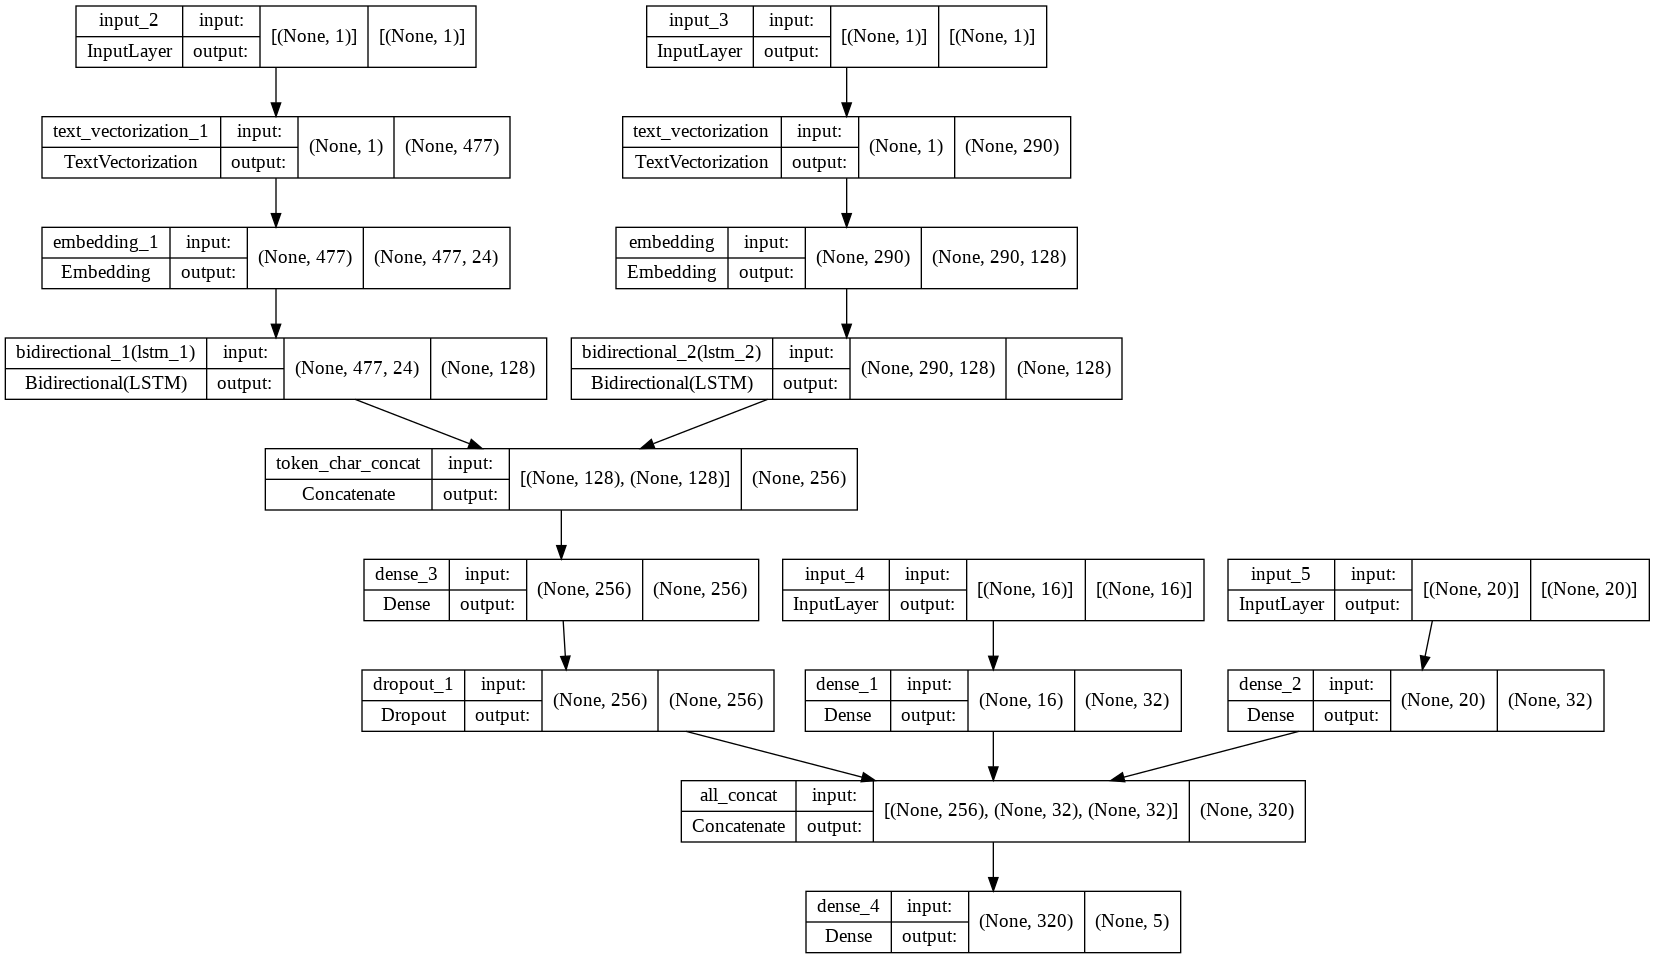

In [55]:
from tensorflow.keras.utils import plot_model
plot_model(model_2, show_shapes=True)

##Setup dataset input pipline

In [56]:
train_concat_input = tf.data.Dataset.from_tensor_slices((train_text,
                                                         train_text_char,
                                                         train_line_numbers_one_hot,
                                                         train_total_lines_one_hot))
train_label = tf.data.Dataset.from_tensor_slices(train_target_one_hot)
train_dataset_concat = tf.data.Dataset.zip((train_concat_input, train_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [57]:
val_concat_input = tf.data.Dataset.from_tensor_slices((val_text,
                                                       val_text_char,
                                                       val_line_numbers_one_hot,
                                                       val_total_lines_one_hot))
val_label = tf.data.Dataset.from_tensor_slices(val_target_one_hot)
val_dataset_concat = tf.data.Dataset.zip((val_concat_input, val_label)).batch(32).prefetch(tf.data.AUTOTUNE)

In [58]:
model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [59]:
history_2 = model_2.fit(train_dataset_concat,
                        epochs=3,
                        steps_per_epoch=int(0.1*len(train_dataset_concat)),
                        validation_data=val_dataset_concat,
                        validation_steps=int(0.1*(len(val_dataset_concat))))

Epoch 1/3
562/562 [==============================] - 83s 110ms/step - loss: 0.9582 - accuracy: 0.8236 - val_loss: 0.9320 - val_accuracy: 0.8291
Epoch 2/3
562/562 [==============================] - 61s 108ms/step - loss: 0.8698 - accuracy: 0.8801 - val_loss: 0.9251 - val_accuracy: 0.8238
Epoch 3/3
562/562 [==============================] - 45s 80ms/step - loss: 0.8565 - accuracy: 0.8866 - val_loss: 0.9112 - val_accuracy: 0.8295


In [60]:
model_2_pred_pro = model_2.predict(val_dataset_concat)

In [61]:
model_2_pred = tf.argmax(model_2_pred_pro, axis=1)
model_2_score = evaluate_results(val_target_le, model_2_pred)
model_2_score

{'model_accuracy': 0.8335429630610354,
 'model_fscore': 0.8329436825645803,
 'model_precision': 0.8357016081236963,
 'model_recall': 0.8335429630610354}

#Compare the results of each model

In [62]:
results_df = pd.DataFrame({'baseline_model': model_0_score,
                          'Bi-LSTM model': model_1_score,
                          'Concatenated model': model_2_score}).transpose()
results_df                          

,model_accuracy,model_precision,model_recall,model_fscore
baseline_model,0.721832,0.718647,0.721832,0.698925
Bi-LSTM model,0.798954,0.798969,0.798954,0.798102
Concatenated model,0.833543,0.835702,0.833543,0.832944


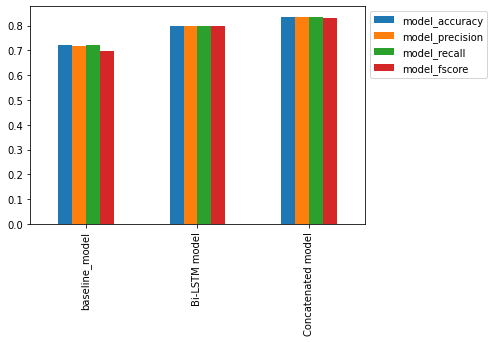

In [63]:
results_df.plot(kind='bar').legend(bbox_to_anchor=(1.0, 1.0))

#Save the best model

In [64]:
#model_2.save('my_model.h5')
#model_2.save('my_model')
#loaded_model = tf.keras.models.load_model('my_model.h5', custom_objects={"KerasLayer": hub.KerasLayer})

#Visualize the most wrong predictions

In [70]:
pred_df = pd.DataFrame({'target': val_target,
                        'text': val_text,
                        'line number': val_line_numbers,
                        'total lines': val_total_lines,
                        'predicted target': label_encoder.classes_[model_2_pred],
                        'predicted probability': tf.math.reduce_max(model_2_pred_pro, axis=1)})
pred_df.head()

,target,text,line number,total lines,predicted target,predicted probability
0,BACKGROUND,IgE sensitization to Aspergillus fumigatus and...,0,9,OBJECTIVE,0.587012
1,BACKGROUND,It is not clear whether these patients would b...,1,9,OBJECTIVE,0.463653
2,OBJECTIVE,We sought to determine whether a @-month cours...,2,9,OBJECTIVE,0.657592
3,METHODS,Asthmatic patients who were IgE sensitized to ...,3,9,METHODS,0.839161
4,METHODS,Primary outcomes were improvement in quality o...,4,9,METHODS,0.759036


In [78]:
pred_wrong_df = pred_df.loc[pred_df['target'] != pred_df['predicted target']].sort_values(by=['predicted probability'], ascending=False)
pred_wrong_df.head(10)

,target,text,line number,total lines,predicted target,predicted probability
7300,BACKGROUND,To examine the effects of complex cognitive ( ...,0,10,OBJECTIVE,0.917142
18208,BACKGROUND,To compare pain response outcomes for patients...,0,10,OBJECTIVE,0.914787
4575,RESULTS,The primary end point was combined cardiac dea...,4,12,METHODS,0.903554
25079,OBJECTIVE,"DESIGN , SUBJECTS , INTERVENTION , OUTCOME MEA...",2,13,METHODS,0.901152
15279,BACKGROUND,To assess the short-term efficacy and safety o...,0,14,OBJECTIVE,0.900024
315,BACKGROUND,To evaluate the efficacy of the surgical fat-f...,0,10,OBJECTIVE,0.898835
27491,RESULTS,Primary end point was the percentage of patien...,4,13,METHODS,0.898376
5947,BACKGROUND,To investigate if the cramp threshold frequenc...,0,10,OBJECTIVE,0.896110
14111,RESULTS,"After a @-week placebo baseline period , @ pat...",3,14,METHODS,0.896017
7392,RESULTS,Sixty patients with chronic ischaemic heart di...,2,14,METHODS,0.895911
